In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05a
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed=RANDOM_STATE)

EPOCHS = 20001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [4]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
<p style="font-family: Arial; font-size:1.1em">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [5]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

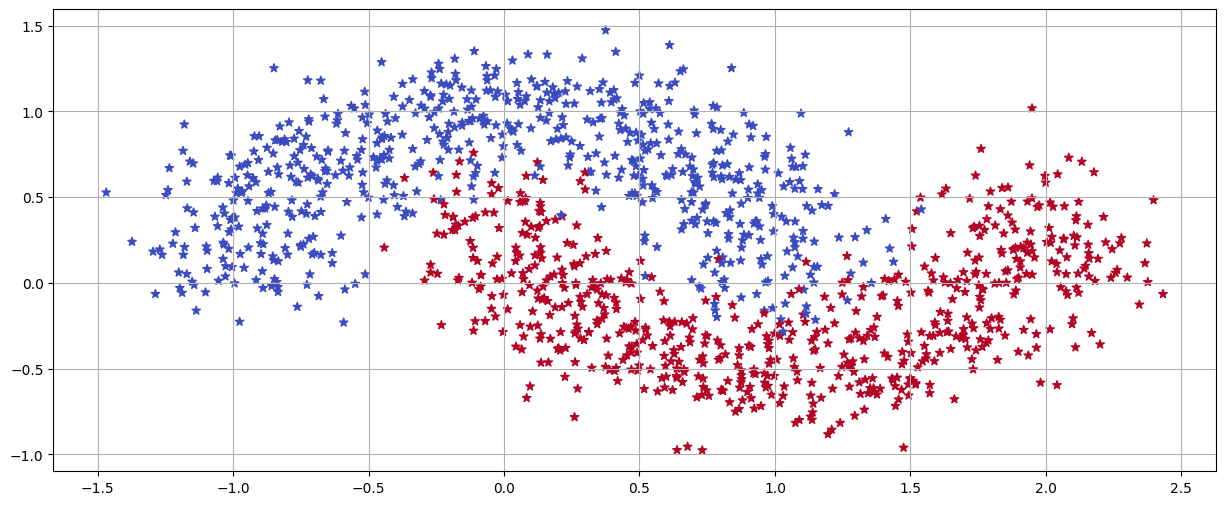

In [6]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP)

plt.grid()

In [7]:
###############################
### Make it multiclass data ###
###############################

y = pd.get_dummies(y).to_numpy()
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [8]:
y.shape

(1280, 2)

In [9]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. Lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src='../../images/dnn_nb_s05_fig1.jpg' width = '500' alt = 'Session 5 Figure 1'/>

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

<img src='../../images/dnn_nb_s05_fig2.jpg' width = '500' alt = 'Session 5 fig 2'/>

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


In [10]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    '''
        Args:
           z : array, Aggregated values 
       Return:
           probs. of each class
    '''
    
    exp_sc = np.exp(z)
    
    return exp_sc / np.sum( exp_sc, axis = 1, keepdims= True)    

In [11]:
sm = fn_softmax(np.asarray([[8, 5, 0], [-10, 0., 10]]))
print (sm, '\n\nTotal of all values', sm.sum(axis = 1))

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]
 [2.06106005e-09 4.53978686e-05 9.99954600e-01]] 

Total of all values [1. 1.]


### Other Activation Function
Keep tanh Function for hidden layer

In [12]:
def fn_activ(x: np.ndarray)-> np.ndarray:

    return np.tanh(x)

def fn_activ_prime(x: np.ndarray)-> np.ndarray:

    return 1.0 - np.tanh(x)**2

## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log(\hat{y_i}) + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log(\hat{y}_i) + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

In [13]:
# function to evaluate the total loss on the dataset

def calculate_loss(model : dict, X: np.ndarray, y: np.ndarray) -> np.float64:
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    
    # extract weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # number of examples
    m = X.shape[0]
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = X.dot(W1) + b1
    
    # Activation
    a1 = fn_activ(z1)
    
    # Layer 2
    z2 = a1.dot(W2) + b2
    
    ###############################
    ### Changes for multi class ###
    ###############################
    # Softmax  Activation
    a2 = fn_softmax(z2)


    # Calculating the loss
    data_loss = -(y * np.log(a2) + (1 - y) * np.log(1 - a2)).sum() 

    return 1./m * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation.

In [14]:
# Helper function to predict an output (0 or 1)

def predict(model : dict, X: np.ndarray) -> np.ndarray:
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = X.dot(W1) + b1
    
    a1 = fn_activ(z1)
    
    z2 = a1.dot(W2) + b2
    
    ###############################
    ### Changes for multi class ###
    ###############################  
    # Softmax Activation
    a2 = fn_softmax(z2)
    
    return np.argmax(a2, axis =1) # pick with one with highest probabilities

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\partial{a^{[1]}}  & = \partial{z^{[2]}} \circ W^{[2]T}\\
\\
\partial{z^{[1]}}  & = \partial{a^{[1]}} * ( 1-z^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$


# Notes:


We have transposed a few matrices in above calculations such as $a^{[1]}$, $W^{[2]}$ and X. A review of shapes of matrices will reveal that this adjustment is needed to have consistent sizes. e.g.

- Shape of $a^{[1]}$ and $\partial{z}^{[2]}$ are ( m, 4) and ( m, 1 ) respectively. Expected shape of $\partial{W^{[2]}}$ is ( 4, 1 ) which is same as that of $W^{[2]}$.
- In equation $\partial{z^{[1]}}  = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-z^{[1]}**2)$ shape of $z^{[2]}$,  $W^{[2]}$ and $a^{[1]}$ are (m,1), (4,1) and (m,4). For element wise multiplication, expected shape of dot product of is $z^{[2]}$ and $W^{[2]}$ is ( m, 4 ).
- Lastly, shape of $\partial{W^{[1]}}$ is (2,4) and that of X and $\partial{z^{[1]}}$ are ( m, 2 ) and ( m, 4 ).

## Prepare Model:

In [ ]:
def build_model(nn_hdim : np.int64, 
                X : np.ndarray, 
                y : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Training features to train
        y : Trainiig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    # number of examples
    m, nn_input_dim = X.shape
    nn_output_dim = y.shape[1]

    # Initialize the parameters to random values. We need to learn these.
    # Weights
    W1 = rng.random((nn_input_dim, nn_hdim)) / np.sqrt(nn_input_dim)
    W2 = rng.random((nn_hdim, nn_output_dim)) / np.sqrt(nn_hdim)
    
    # Bias
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0
    loss = []
    epoch = []
    
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1
        
        # Activation function for layer 1
        a1 = fn_activ(z1)  
        
        # Layer 2
        z2 = a1.dot(W2) + b2
        
        ###############################
        ### Changes for multi class ###
        ###############################
        a2 = fn_softmax(z2)

        #######################
        #   Back propagation  #
        #######################
        # Layer 2
        dz2 = a2-y

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) # db2 is sum along axis 0
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
        
        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), 'Shape of a1 {} and shape of da1 {}'.format(a1.shape, da1.shape)

        # Layer 1
        dz1 = da1 * fn_activ_prime(z1)  #derivative of Activation Function
        #                               '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
        
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/m
        b1 += -alpha * db1/m
        W2 += -alpha * dW2/m
        b2 += -alpha * db2/m
        
        #  Model as a Dict object to be return.
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
        
        # Print the loss.
        if i % 1000 == 0:
            print("Loss after iteration %5i: %.5f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [16]:
# lists to facilitate plotting 
loss_hist = {}

In [17]:
# Build a model with a 4-dimensional hidden layer
model = build_model(4, X_train, y_train,
                    epochs = EPOCHS, 
                    alpha = ALPHA)

Loss after iteration     0: 0.00000
Loss after iteration  1000: 0.59760
Loss after iteration  2000: 0.58786
Loss after iteration  3000: 0.37010
Loss after iteration  4000: 0.25419
Loss after iteration  5000: 0.19735
Loss after iteration  6000: 0.16933
Loss after iteration  7000: 0.15842
Loss after iteration  8000: 0.15367
Loss after iteration  9000: 0.15123
Loss after iteration 10000: 0.14977
Loss after iteration 11000: 0.14877
Loss after iteration 12000: 0.14802
Loss after iteration 13000: 0.14741
Loss after iteration 14000: 0.14690
Loss after iteration 15000: 0.14647
Loss after iteration 16000: 0.14610
Loss after iteration 17000: 0.14579
Loss after iteration 18000: 0.14551
Loss after iteration 19000: 0.14528
Loss after iteration 20000: 0.14507


In [18]:
model

{'W1': array([[ 3.12841719, -2.83134975, -2.31975354,  0.40241767],
        [ 1.72708866,  1.40667184,  1.41374663,  0.14985261]]),
 'b1': array([[-1.88875467, -1.3282204 ,  2.86858188, -0.14439402]]),
 'W2': array([[ 4.62249874, -3.84107747],
        [ 3.43998147, -2.87893863],
        [ 3.95475064, -3.46779918],
        [-2.0419159 ,  2.7444102 ]]),
 'b2': array([[-0.19944505,  0.19944505]])}

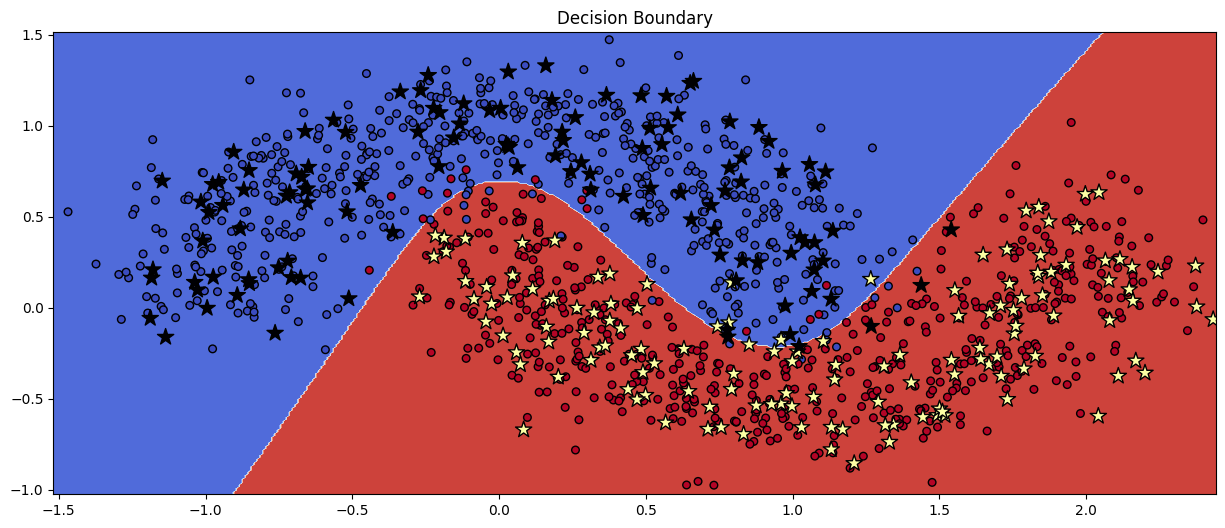

In [19]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train, X_test, y_test) # plot decision boundary for this plot

plt.title("Decision Boundary");

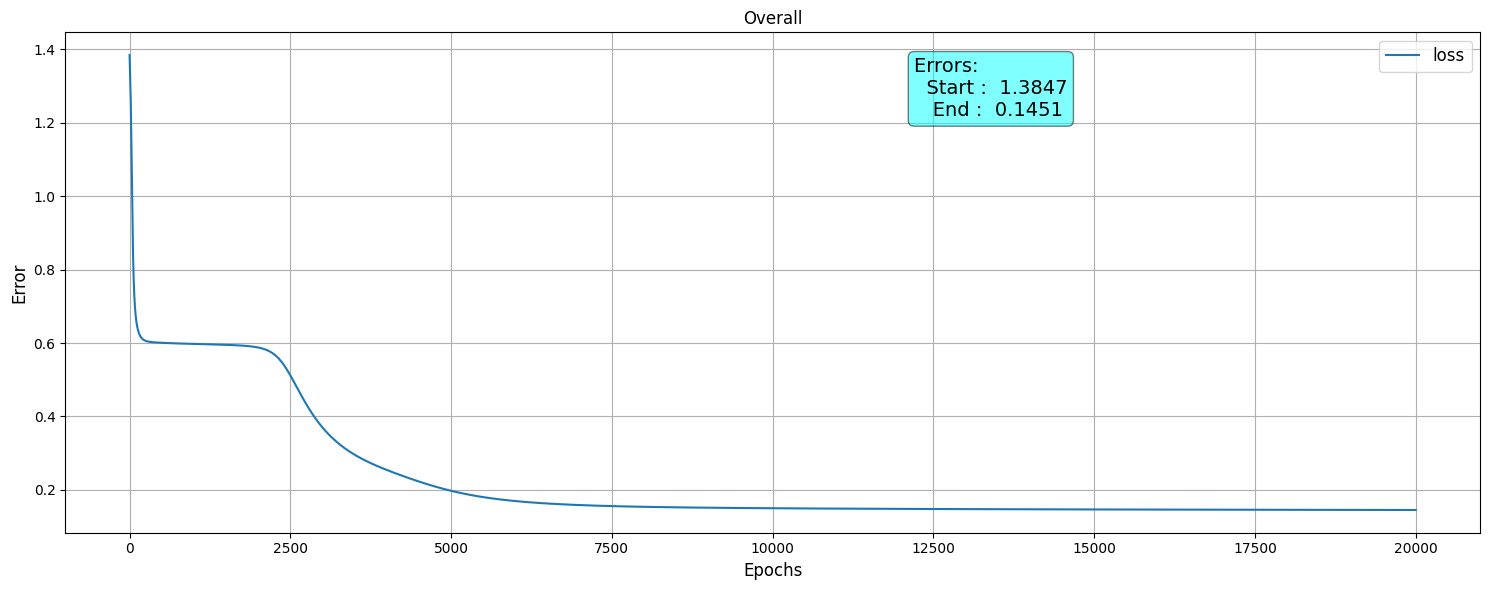

In [20]:
fig, ax = plt.subplots()

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0]['loss'],
                                                                loss_df.iloc[-1]['loss']) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid(True);

plt.tight_layout()

## Predictions
### Train Data

In [21]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

Accuracy score on Train Data : 0.96875


In [22]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       522
           1       0.97      0.97      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



### Test Data

In [23]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.9609375


In [24]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.96      0.96      0.96       138

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



In [25]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[113,   5],
       [  5, 133]])

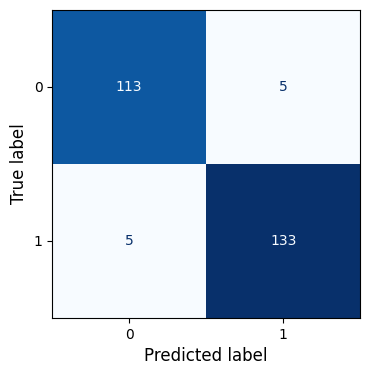

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();